<a href="https://colab.research.google.com/github/thao-encord/rubric-eval-encord-wandb/blob/main/rubric_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric Evaluation Analysis with Weighted Scoring

This notebook implements comprehensive weighted scoring analysis with multiple visualizations.


In [ ]:
!python -m pip install rich pandas matplotlib seaborn

In [ ]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rich.table import Table
from rich.panel import Panel
from rich import print as rprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


np.seterr(all="ignore")  # Suppresses all numpy warnings globally

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline

Some constants to make code simpler.

In [ ]:
# Ontology
PROPERTIES = [
    (
        "Audio Quality",
        [
            "Clarity",
            "Naturalness",
            "Volume Consistency",
            "Background Noise",
            "Pitch and Tone",
            "Audio Format",
        ],
    ),
    (
        "Spoken Language Quality",
        [
            "Grammar and Syntax",
            "Coherence",
            "Pronunciation Accuracy",
            "Fluency",
            "Prosody",
            "Handling of Complex Sentences",
        ],
    ),
    (
        "Prompt Alignment",
        [
            "Fidelity to Text",
            "Formatting Preservation",
            "Special Characters",
            "Ambiguity Handling",
            "Contextual Relevance",
        ],
    ),
    (
        "Correctness",
        [
            "Transcription Accuracy",
            "Error Detection",
            "Consistency with Input",
            "Adherence to Constraints",
            "Error Handling",
        ],
    ),
]
COLUMNS = [f"[{k[0]}] {v}" for k, vals in PROPERTIES for v in vals]

CATEGORY_NAMES = {name[0]: name for name, _ in PROPERTIES}

# We will color code charts and tables based on the rubric groups.
# This dictionary is used to define the colors.
CATEGORY_COLORS = {
    "A": "#00afff",  # "skyblue",
    "S": "#ff0000",  # "lightcoral",
    "P": "#ffd700",  #  "gold"
    "C": "#00d700",  # "lightgreen",
}
print(f"{CATEGORY_COLORS=}")
print(f"{CATEGORY_NAMES=}")
print(f"{COLUMNS=}")

CATEGORY_COLORS={'A': '#00afff', 'S': '#ff0000', 'P': '#ffd700', 'C': '#00d700'}
CATEGORY_NAMES={'A': 'Audio Quality', 'S': 'Spoken Language Quality', 'P': 'Prompt Alignment', 'C': 'Correctness'}
COLUMNS=['[A] Clarity', '[A] Naturalness', '[A] Volume Consistency', '[A] Background Noise', '[A] Pitch and Tone', '[A] Audio Format', '[S] Grammar and Syntax', '[S] Coherence', '[S] Pronunciation Accuracy', '[S] Fluency', '[S] Prosody', '[S] Handling of Complex Sentences', '[P] Fidelity to Text', '[P] Formatting Preservation', '[P] Special Characters', '[P] Ambiguity Handling', '[P] Contextual Relevance', '[C] Transcription Accuracy', '[C] Error Detection', '[C] Consistency with Input', '[C] Adherence to Constraints', '[C] Error Handling']


### Specifying weighting

In [ ]:
# Notice that the weights here correspond to the columns in the `COLUMNS` variable.

# If you need a template, here is one:
# print(json.dumps({c: round(1/len(COLUMNS), 3) for c in COLUMNS}, indent=4))

WEIGHTS_DICT = {
    "[A] Clarity": 0.05,
    "[A] Naturalness": 0.05,
    "[A] Volume Consistency": 0.05,
    "[A] Background Noise": 0.05,
    "[A] Pitch and Tone": 0.05,
    "[A] Audio Format": 0.05,
    "[S] Grammar and Syntax": 0.03,
    "[S] Coherence": 0.06,
    "[S] Pronunciation Accuracy": 0.03,
    "[S] Fluency": 0.05,
    "[S] Prosody": 0.05,
    "[S] Handling of Complex Sentences": 0.03,
    "[P] Fidelity to Text": 0.06,
    "[P] Formatting Preservation": 0.06,
    "[P] Special Characters": 0.07,
    "[P] Ambiguity Handling": 0.06,
    "[P] Contextual Relevance": 0.06,
    "[C] Transcription Accuracy": 0.06,
    "[C] Error Detection": 0.02,
    "[C] Consistency with Input": 0.05,
    "[C] Adherence to Constraints": 0.05,
    "[C] Error Handling": 0.02,
}


In [ ]:
def weights_to_df(weights_dict: dict[str, float]) -> pd.DataFrame:
    """Load and process weights from JSON file into numpy array."""
    # Create weights array in the same order as PROPERTIES
    weights = [weights_dict[c] for c in COLUMNS]
    weights = np.array(weights)
    weights = weights / np.sum(weights)  # normalize such that they sum to one.

    print(f"Loaded {len(weights)} weights, sum: {np.sum(weights):.6f}")
    return pd.DataFrame(weights[None], columns=COLUMNS)


weights = weights_to_df(WEIGHTS_DICT)
weights.head()

Loaded 22 weights, sum: 1.000000


,[A] Clarity,[A] Naturalness,[A] Volume Consistency,[A] Background Noise,[A] Pitch and Tone,[A] Audio Format,[S] Grammar and Syntax,[S] Coherence,[S] Pronunciation Accuracy,[S] Fluency,...,[P] Fidelity to Text,[P] Formatting Preservation,[P] Special Characters,[P] Ambiguity Handling,[P] Contextual Relevance,[C] Transcription Accuracy,[C] Error Detection,[C] Consistency with Input,[C] Adherence to Constraints,[C] Error Handling
0,0.04717,0.04717,0.04717,0.04717,0.04717,0.04717,0.028302,0.056604,0.028302,0.04717,...,0.056604,0.056604,0.066038,0.056604,0.056604,0.056604,0.018868,0.04717,0.04717,0.018868


### Loading Evaluation Data

Loading annotations. They are supposed to be in a csv file with the following format:
```csv
[A] Clarity,[A] Naruralness,...
0.5,1.0,0.0
...
```
With scores `1.0`, `0.5`, and `0.0` meaning "Good", "Partial", and "Bad", respectively.

The script below will download example data that you can patternmatch against.

In [ ]:
def load_evaluation(path: Path):
    """Load the generated evaluation data."""
    if not path.exists() and path.name in ["model1_data.csv", "model2_data.csv"]:
        url = {
            "model1_data.csv": "https://storage.googleapis.com/encord-notebooks/rubric_evaluation/model1_data.csv",
            "model2_data.csv": "https://storage.googleapis.com/encord-notebooks/rubric_evaluation/model2_data.csv",
        }[path.name]
        df = pd.read_csv(url)
        df.to_csv(path, index=False)
    elif not path.exists():
        raise FileNotFoundError(f"File {path} not found")

    df = pd.read_csv(path)
    assert len(set(df.columns.tolist()).symmetric_difference(set(COLUMNS))) == 0, (
        f"Columns in {path} do not match expected columns from the `COLUMNS` variable. \n"
        f"Expected: {COLUMNS}\nFound: {df.columns.tolist()}"
    )
    return df


print(Path("model1_data.csv").exists())
model1_df = load_evaluation(Path("model1_data.csv"))
model2_df = load_evaluation(Path("model2_data.csv"))

model1_df.head()


False


,[A] Clarity,[A] Naturalness,[A] Volume Consistency,[A] Background Noise,[A] Pitch and Tone,[A] Audio Format,[S] Grammar and Syntax,[S] Coherence,[S] Pronunciation Accuracy,[S] Fluency,...,[P] Fidelity to Text,[P] Formatting Preservation,[P] Special Characters,[P] Ambiguity Handling,[P] Contextual Relevance,[C] Transcription Accuracy,[C] Error Detection,[C] Consistency with Input,[C] Adherence to Constraints,[C] Error Handling
0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,...,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,...,1.0,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Overall scores


In [ ]:
### Core Computation, matrix multiplication
def weight_scores(df, weights):
    return df @ weights.T


def print_scores(df1, df2, weights, title: str = ""):
    # Unweighted scores
    uniform_weights = np.ones((1, df1.shape[1]))
    aggr1 = weight_scores(df1, uniform_weights).mean().item()
    aggr2 = weight_scores(df2, uniform_weights).mean().item()

    # Here computing all scores for each
    weighted1 = weight_scores(df1, weights).mean().item()
    weighted2 = weight_scores(df2, weights).mean().item()

    # Print results
    table = Table("Model", "Aggregate", "Weighted")
    table.add_row("Model 1", f"{aggr1:.3f}", f"{weighted1:.3f}")
    table.add_row("Model 2", f"{aggr2:.3f}", f"{weighted2:.3f}")
    color = CATEGORY_COLORS.get(title[0], "black")
    panel = Panel(table, title=title, expand=False, style=color)
    rprint(panel)


print_scores(model1_df, model2_df, weights, "Overall")

print("By Group:")
for grp_name, _ in PROPERTIES:
    columns = model1_df.columns[model1_df.columns.str.slice(1, 2) == grp_name[0]]
    group1 = model1_df[columns]
    group2 = model2_df[columns]
    group_weights = weights[columns] / weights[columns].sum(axis=1)[0]
    print_scores(group1, group2, group_weights, title=grp_name)

╭───────────── Overall ──────────────╮
│ ┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓ │
│ ┃ Model   ┃ Aggregate ┃ Weighted ┃ │
│ ┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩ │
│ │ Model 1 │ 20.538    │ 0.925    │ │
│ │ Model 2 │ 20.985    │ 0.948    │ │
│ └─────────┴───────────┴──────────┘ │
╰────────────────────────────────────╯

By Group:


╭────────── Audio Quality ───────────╮
│ ┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓ │
│ ┃ Model   ┃ Aggregate ┃ Weighted ┃ │
│ ┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩ │
│ │ Model 1 │ 5.758     │ 0.960    │ │
│ │ Model 2 │ 5.817     │ 0.970    │ │
│ └─────────┴───────────┴──────────┘ │
╰────────────────────────────────────╯

╭───── Spoken Language Quality ──────╮
│ ┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓ │
│ ┃ Model   ┃ Aggregate ┃ Weighted ┃ │
│ ┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩ │
│ │ Model 1 │ 5.812     │ 0.968    │ │
│ │ Model 2 │ 5.827     │ 0.970    │ │
│ └─────────┴───────────┴──────────┘ │
╰────────────────────────────────────╯

╭───────── Prompt Alignment ─────────╮
│ ┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓ │
│ ┃ Model   ┃ Aggregate ┃ Weighted ┃ │
│ ┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩ │
│ │ Model 1 │ 4.178     │ 0.835    │ │
│ │ Model 2 │ 4.495     │ 0.898    │ │
│ └─────────┴───────────┴──────────┘ │
╰────────────────────────────────────╯

╭─────────── Correctness ────────────╮
│ ┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓ │
│ ┃ Model   ┃ Aggregate ┃ Weighted ┃ │
│ ┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩ │
│ │ Model 1 │ 4.790     │ 0.958    │ │
│ │ Model 2 │ 4.845     │ 0.968    │ │
│ └─────────┴───────────┴──────────┘ │
╰────────────────────────────────────╯

## Weighted Comparison Heatmap

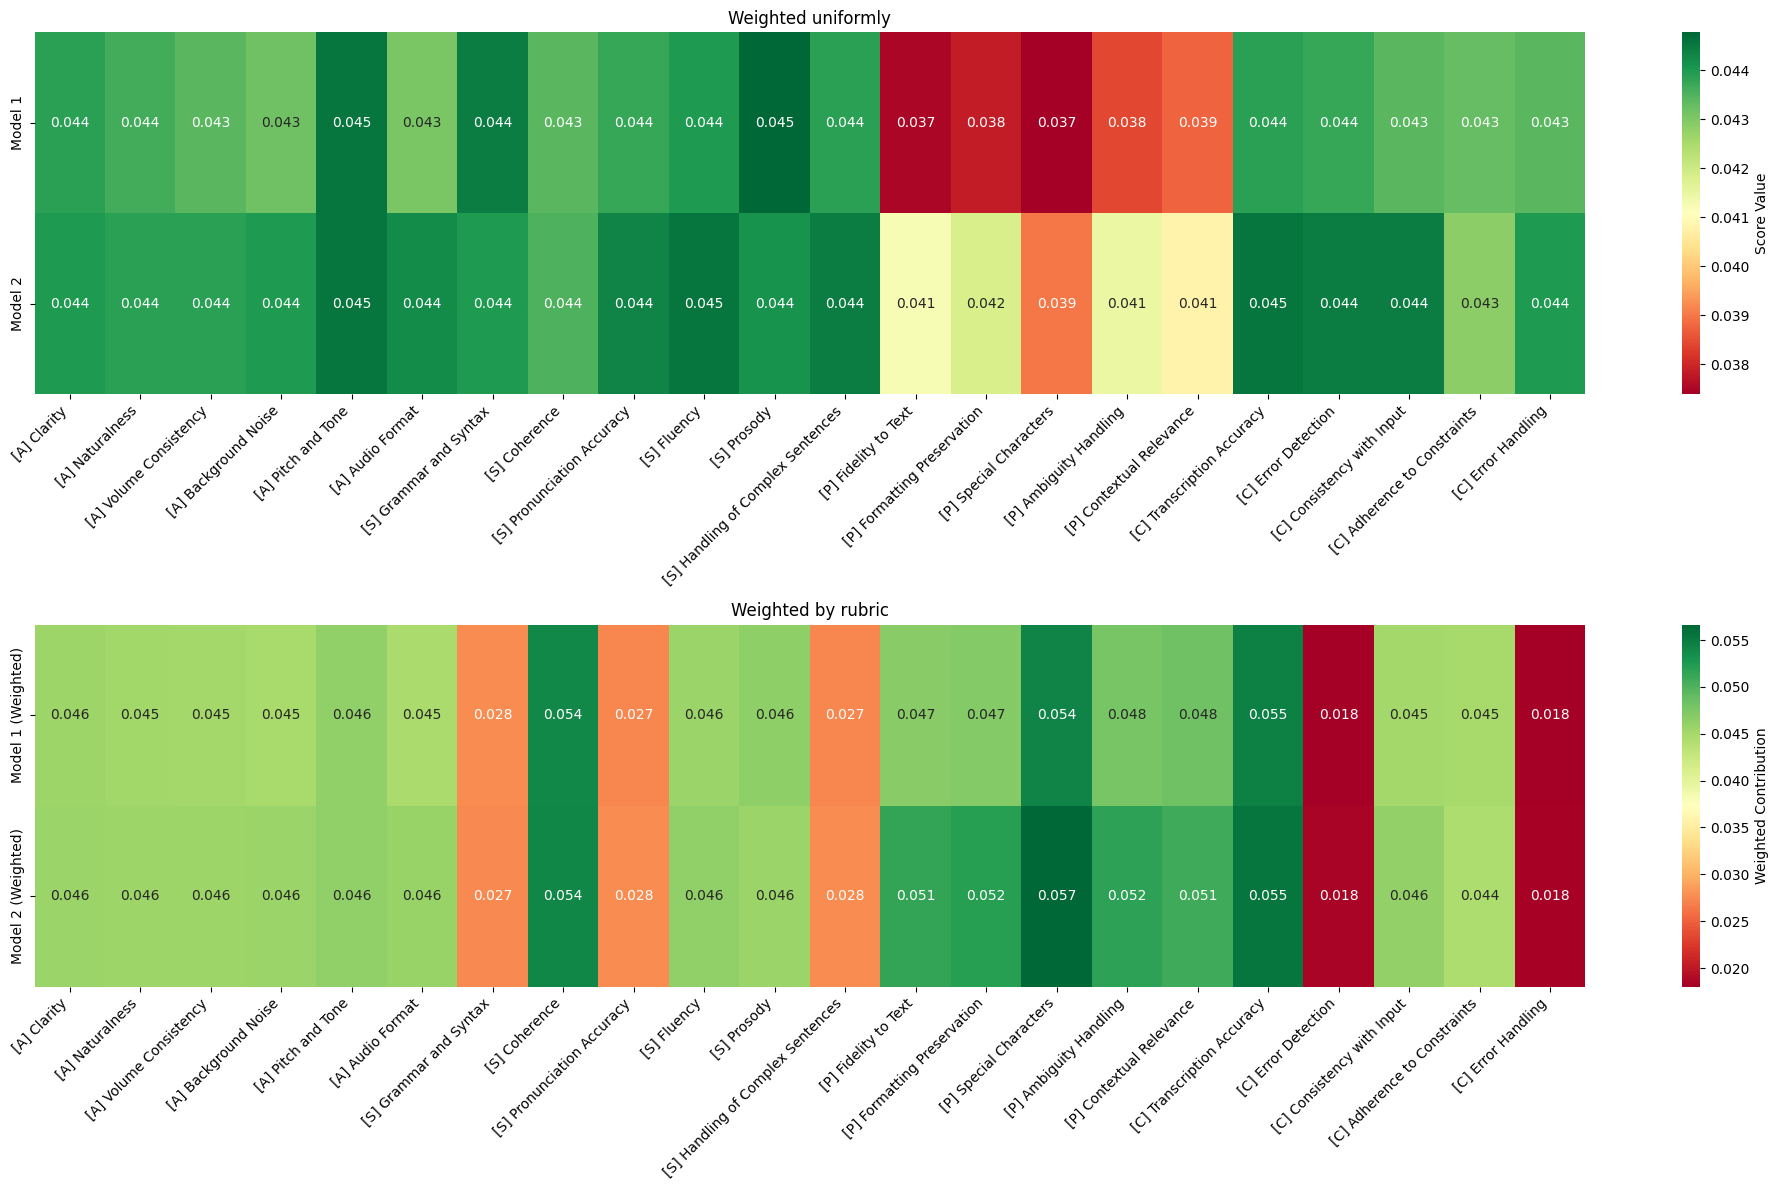

In [ ]:
# Plot 1: Weighted Comparison Heatmap (Clean Pandas Approach)
def plot_weighted_comparison_heatmap():
    """Plot 1: Heatmap comparing raw scores vs weighted contributions."""
    # Calculate means using pandas
    model1_means = model1_df.mean()
    model2_means = model2_df.mean()
    weights_series = weights.iloc[0]  # Extract weights as Series
    uniform_weights = np.ones((model1_df.shape[1],)) / model1_df.shape[1]

    # Calculate weighted contributions
    uniform_model1_contributions = model1_means * uniform_weights
    uniform_model2_contributions = model2_means * uniform_weights

    weighted_model1_contributions = model1_means * weights_series
    weighted_model2_contributions = model2_means * weights_series

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

    # Prepare data for heatmap
    raw_data = pd.DataFrame(
        {
            "Model 1": uniform_model1_contributions,
            "Model 2": uniform_model2_contributions,
        }
    ).T

    weighted_data = pd.DataFrame(
        {
            "Model 1 (Weighted)": weighted_model1_contributions,
            "Model 2 (Weighted)": weighted_model2_contributions,
        }
    ).T

    # Plot 1: Raw scores with weights
    sns.heatmap(
        raw_data,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        ax=ax1,
        cbar_kws={"label": "Score Value"},
    )
    ax1.set_title("Weighted uniformly")
    ax1.set_xticklabels(raw_data.columns, rotation=45, ha="right")

    # Plot 2: Weighted contributions
    sns.heatmap(
        weighted_data,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        ax=ax2,
        cbar_kws={"label": "Weighted Contribution"},
    )
    ax2.set_title("Weighted by rubric")
    ax2.set_xticklabels(weighted_data.columns, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


plot_weighted_comparison_heatmap()


## Box Plots

By Group:


/tmp/ipython-input-9-2242374020.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-9-2242374020.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


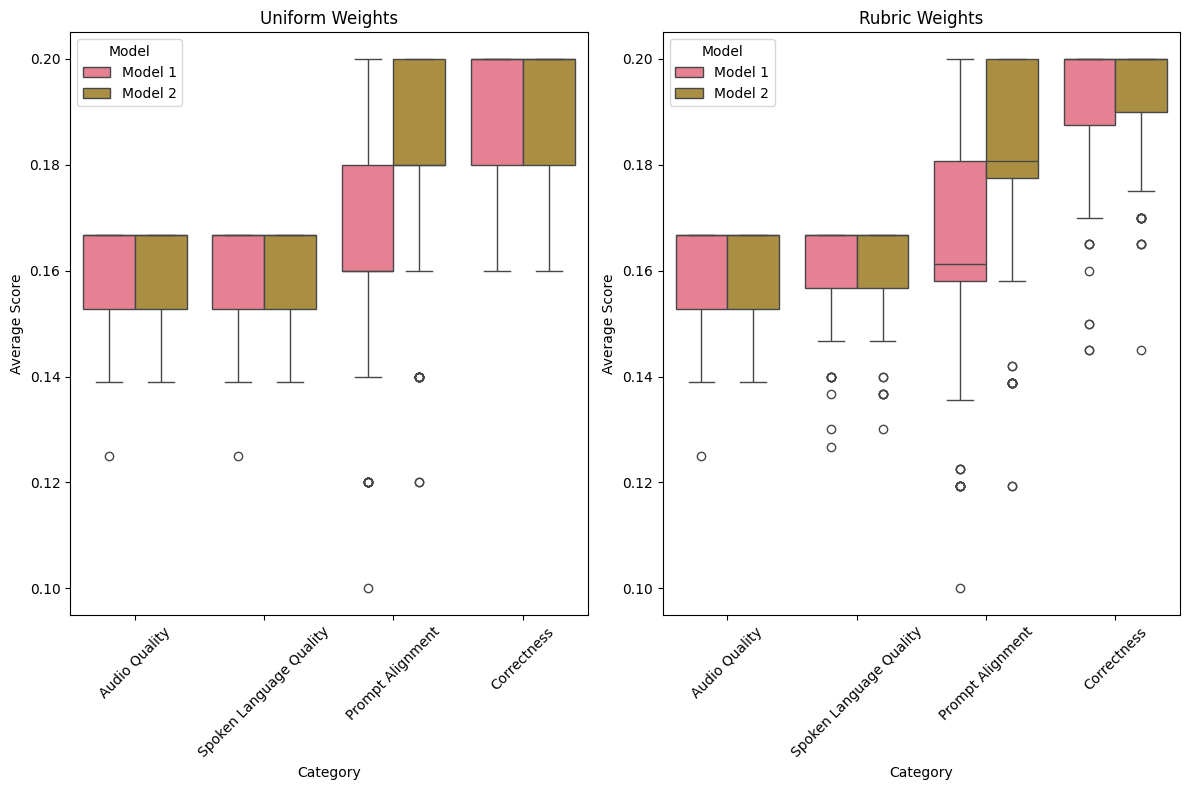

In [ ]:
# Plot 2: Category Analysis (Clean Pandas Approach)
def plot_category_analysis():
    """Plot 2: Box plots showing performance by category."""

    # Prepare data for plotting
    plot_data_uniform = []
    plot_data_weighted = []

    print("By Group:")
    for grp_name, _ in PROPERTIES:
        cat = grp_name[0]
        columns = model1_df.columns[model1_df.columns.str.slice(1, 2) == cat]
        # Uniform weights
        group_weights = np.ones((columns.shape[0])) / columns.shape[0]
        group1 = (model1_df[columns] * group_weights).mean(axis=1)
        group2 = (model2_df[columns] * group_weights).mean(axis=1)

        for score in group1:
            plot_data_uniform.append(
                {"Category": grp_name, "Model": "Model 1", "Score": score}
            )
        for score in group2:
            plot_data_uniform.append(
                {"Category": grp_name, "Model": "Model 2", "Score": score}
            )

        # Rubric weights
        group_weights = (weights[columns] / weights[columns].sum(axis=1)[0]).iloc[0]
        group1 = (model1_df[columns] * group_weights).mean(axis=1)
        group2 = (model2_df[columns] * group_weights).mean(axis=1)

        for score in group1:
            plot_data_weighted.append(
                {"Category": grp_name, "Model": "Model 1", "Score": score}
            )
        for score in group2:
            plot_data_weighted.append(
                {"Category": grp_name, "Model": "Model 2", "Score": score}
            )

    df_uniform = pd.DataFrame(plot_data_uniform)
    df_weighted = pd.DataFrame(plot_data_weighted)

    # Uniform weights
    _, axs = plt.subplots(1, 2, figsize=(12, 8))
    ax = sns.boxplot(data=df_uniform, x="Category", y="Score", hue="Model", ax=axs[0])
    ax.set_title("Uniform Weights")
    ax.set_ylabel("Average Score")
    ax.legend(title="Model")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Rubric weights
    ax = sns.boxplot(data=df_weighted, x="Category", y="Score", hue="Model", ax=axs[1])
    ax.set_title("Rubric Weights")
    ax.set_ylabel("Average Score")
    ax.legend(title="Model")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_category_analysis()


# Improvement analysis


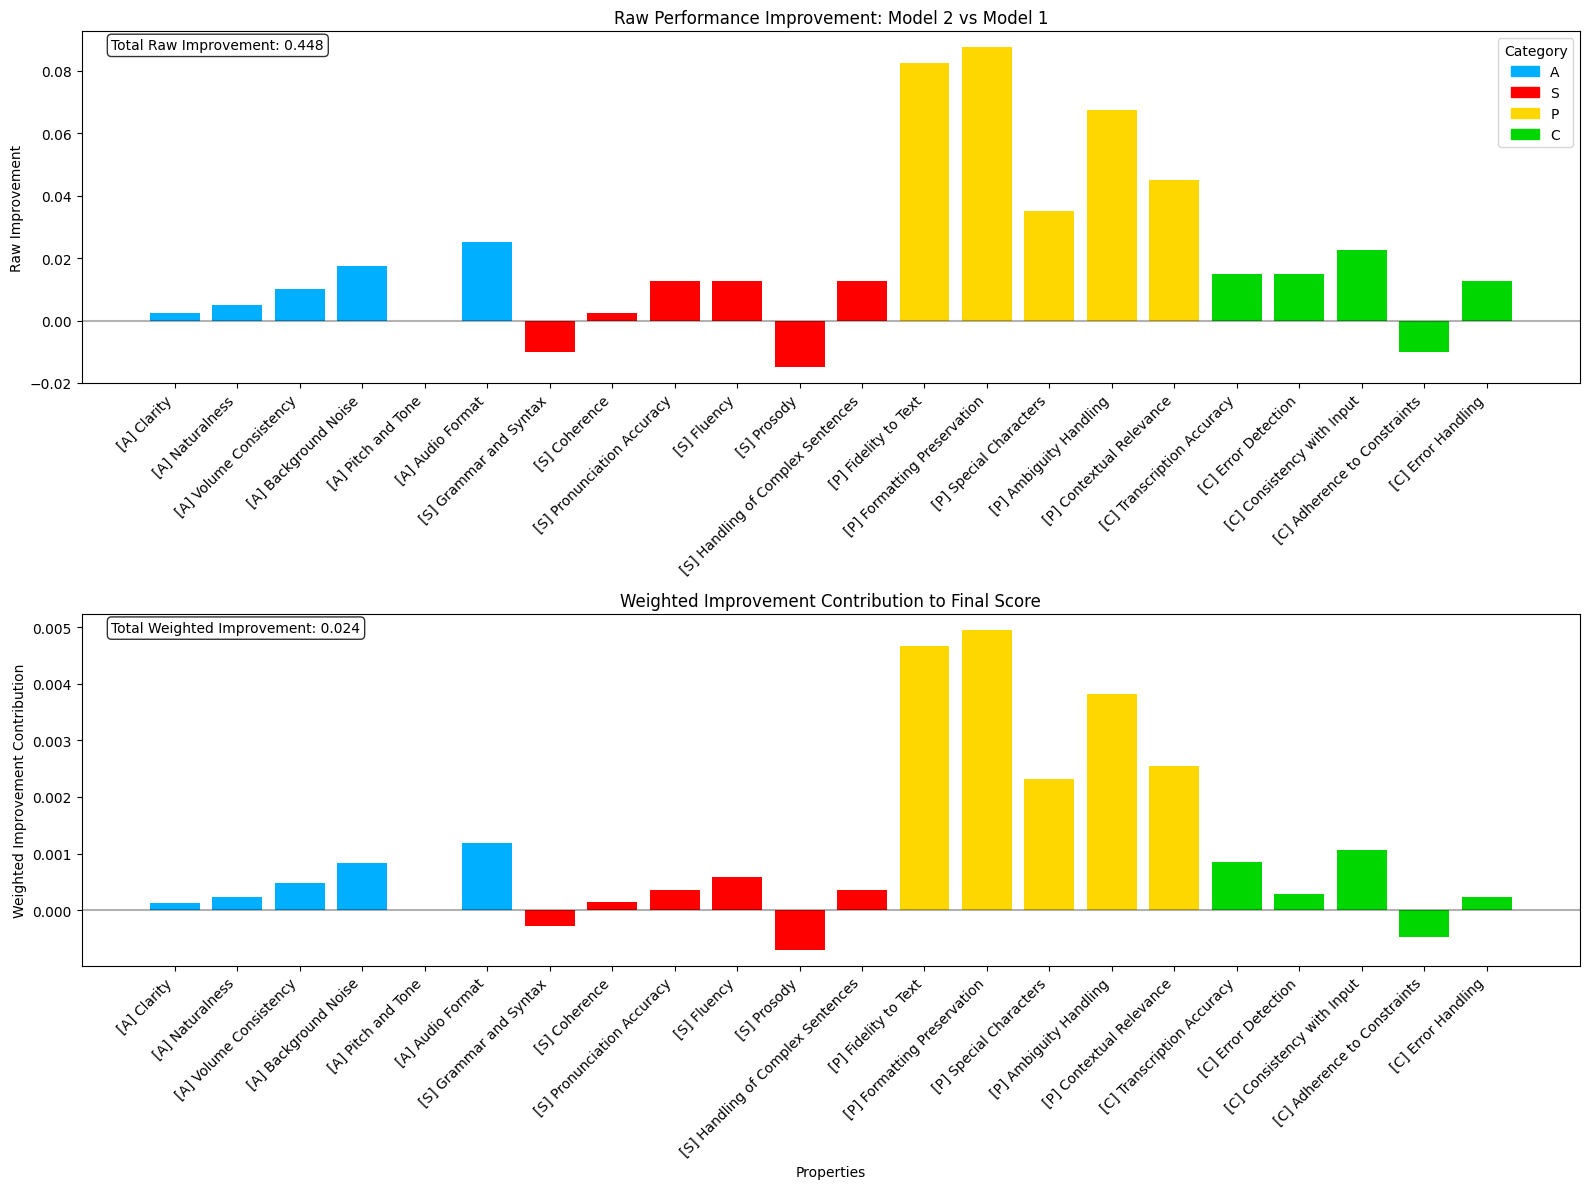

In [ ]:
# Plot 3: Improvement Analysis (Clean Pandas Approach)
def plot_improvement_analysis(model1_df, model2_df, weights):
    """Plot 3: Analysis showing improvement patterns across properties."""
    # Calculate improvements (Model 2 - Model 1)
    model1_means = model1_df.mean()
    model2_means = model2_df.mean()
    improvements = model2_means - model1_means
    weights_series = weights.iloc[0]

    # Calculate weighted improvements
    weighted_improvements = improvements * weights_series

    # Create DataFrame for easier plotting
    df_improvements = pd.DataFrame(
        {
            "Property": improvements.index,
            "Raw_Improvement": improvements.values,
            "Weighted_Improvement": weighted_improvements.values,
            "Weight": weights_series.values,
        }
    )

    # Add category information
    df_improvements["Category"] = df_improvements["Property"].str[
        1
    ]  # Extract category letter
    df_improvements["Color"] = df_improvements["Category"].map(CATEGORY_COLORS)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # Plot 1: Raw improvements
    ax1.bar(
        range(len(df_improvements)),
        df_improvements["Raw_Improvement"],
        color=df_improvements["Color"],
    )
    ax1.axhline(y=0, color="black", linestyle="-", alpha=0.3)
    ax1.set_title("Raw Performance Improvement: Model 2 vs Model 1")
    ax1.set_ylabel("Raw Improvement")
    ax1.set_xticks(range(len(df_improvements)))
    ax1.set_xticklabels(df_improvements["Property"], rotation=45, ha="right")

    # Plot 2: Weighted improvements
    ax2.bar(
        range(len(df_improvements)),
        df_improvements["Weighted_Improvement"],
        color=df_improvements["Color"],
    )
    ax2.axhline(y=0, color="black", linestyle="-", alpha=0.3)
    ax2.set_title("Weighted Improvement Contribution to Final Score")
    ax2.set_xlabel("Properties")
    ax2.set_ylabel("Weighted Improvement Contribution")
    ax2.set_xticks(range(len(df_improvements)))
    ax2.set_xticklabels(df_improvements["Property"], rotation=45, ha="right")

    # Add legend
    import matplotlib.patches as mpatches

    legend_elements = [
        mpatches.Patch(color=color, label=cat) for cat, color in CATEGORY_COLORS.items()
    ]
    ax1.legend(handles=legend_elements, title="Category")

    # Add summary statistics
    total_raw = df_improvements["Raw_Improvement"].sum()
    total_weighted = df_improvements["Weighted_Improvement"].sum()
    ax1.text(
        0.02,
        0.98,
        f"Total Raw Improvement: {total_raw:.3f}",
        transform=ax1.transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )
    ax2.text(
        0.02,
        0.98,
        f"Total Weighted Improvement: {total_weighted:.3f}",
        transform=ax2.transAxes,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()


plot_improvement_analysis(model1_df, model2_df, weights)


## Overall score comparison

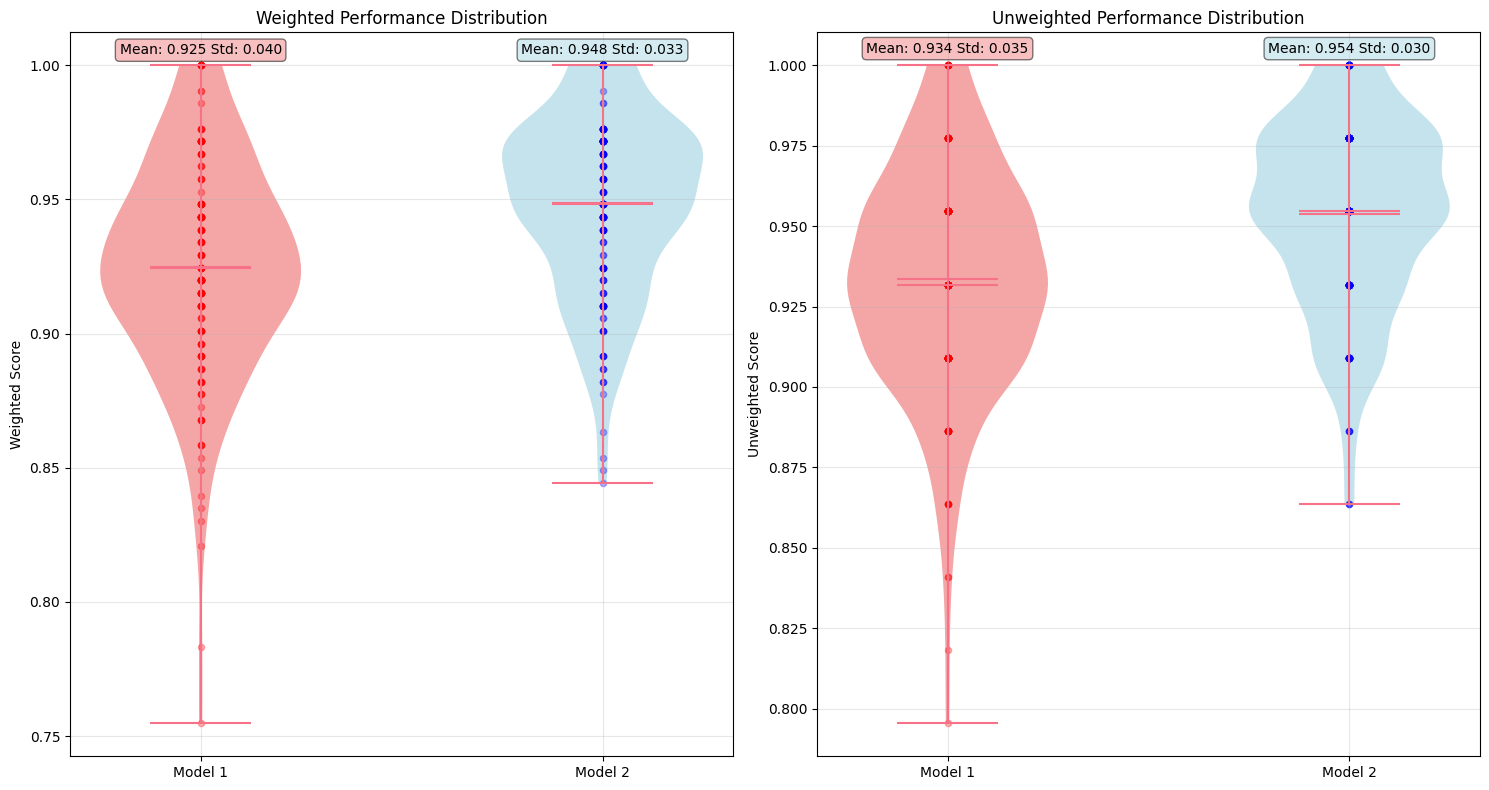

In [ ]:
# Plot 4: Overall Score Comparison (Clean Pandas Approach)
def plot_overall_comparison(model1_df, model2_df, weights):
    """Plot 4: Overall weighted vs unweighted score distributions."""
    uniform_weights = pd.DataFrame(np.ones((1, model1_df.shape[1])) / model1_df.shape[1], columns=model1_df.columns)
    model1_unweighted_scores = model1_df @ uniform_weights.T
    model2_unweighted_scores = model2_df @ uniform_weights.T

    # Weighted scores
    model1_weighted_scores = model1_df @ weights.T
    model2_weighted_scores = model2_df @ weights.T

    # Flatten scores for violin plots
    model1_unweighted_flat = model1_unweighted_scores.iloc[:, 0]
    model2_unweighted_flat = model2_unweighted_scores.iloc[:, 0]
    model1_weighted_flat = model1_weighted_scores.iloc[:, 0]
    model2_weighted_flat = model2_weighted_scores.iloc[:, 0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

    # Plot 1: Weighted scores
    data_weighted = [model1_weighted_flat, model2_weighted_flat]
    parts1 = ax1.violinplot(data_weighted, positions=[1, 2], showmeans=True, showmedians=True)

    colors = ['lightcoral', 'lightblue']
    for pc, color in zip(parts1['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    ax1.scatter([1] * len(model1_weighted_flat), model1_weighted_flat, alpha=0.3, s=20, color='red')
    ax1.scatter([2] * len(model2_weighted_flat), model2_weighted_flat, alpha=0.3, s=20, color='blue')

    ax1.set_xticks([1, 2])
    ax1.set_xticklabels(['Model 1', 'Model 2'])
    ax1.set_ylabel('Weighted Score')
    ax1.set_title('Weighted Performance Distribution')
    ax1.grid(True, alpha=0.3)

    # Add statistics
    ax1.text(1, model1_weighted_flat.max() + 0.003,
             f'Mean: {model1_weighted_flat.mean():.3f} Std: {model1_weighted_flat.std():.3f}',
             ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    ax1.text(2, model2_weighted_flat.max() + 0.003,
             f'Mean: {model2_weighted_flat.mean():.3f} Std: {model2_weighted_flat.std():.3f}',
             ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # Plot 2: Unweighted scores
    data_unweighted = [model1_unweighted_flat, model2_unweighted_flat]
    parts2 = ax2.violinplot(data_unweighted, positions=[1, 2], showmeans=True, showmedians=True)

    for pc, color in zip(parts2['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    ax2.scatter([1] * len(model1_unweighted_flat), model1_unweighted_flat, alpha=0.3, s=20, color='red')
    ax2.scatter([2] * len(model2_unweighted_flat), model2_unweighted_flat, alpha=0.3, s=20, color='blue')

    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['Model 1', 'Model 2'])
    ax2.set_ylabel('Unweighted Score')
    ax2.set_title('Unweighted Performance Distribution')
    ax2.grid(True, alpha=0.3)

    # Add statistics
    ax2.text(1, model1_unweighted_flat.max() + 0.003,
             f'Mean: {model1_unweighted_flat.mean():.3f} Std: {model1_unweighted_flat.std():.3f}',
             ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    ax2.text(2, model2_unweighted_flat.max() + 0.003,
             f'Mean: {model2_unweighted_flat.mean():.3f} Std: {model2_unweighted_flat.std():.3f}',
             ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.show()

plot_overall_comparison(model1_df, model2_df, weights)


## Weight Distribution Analysis

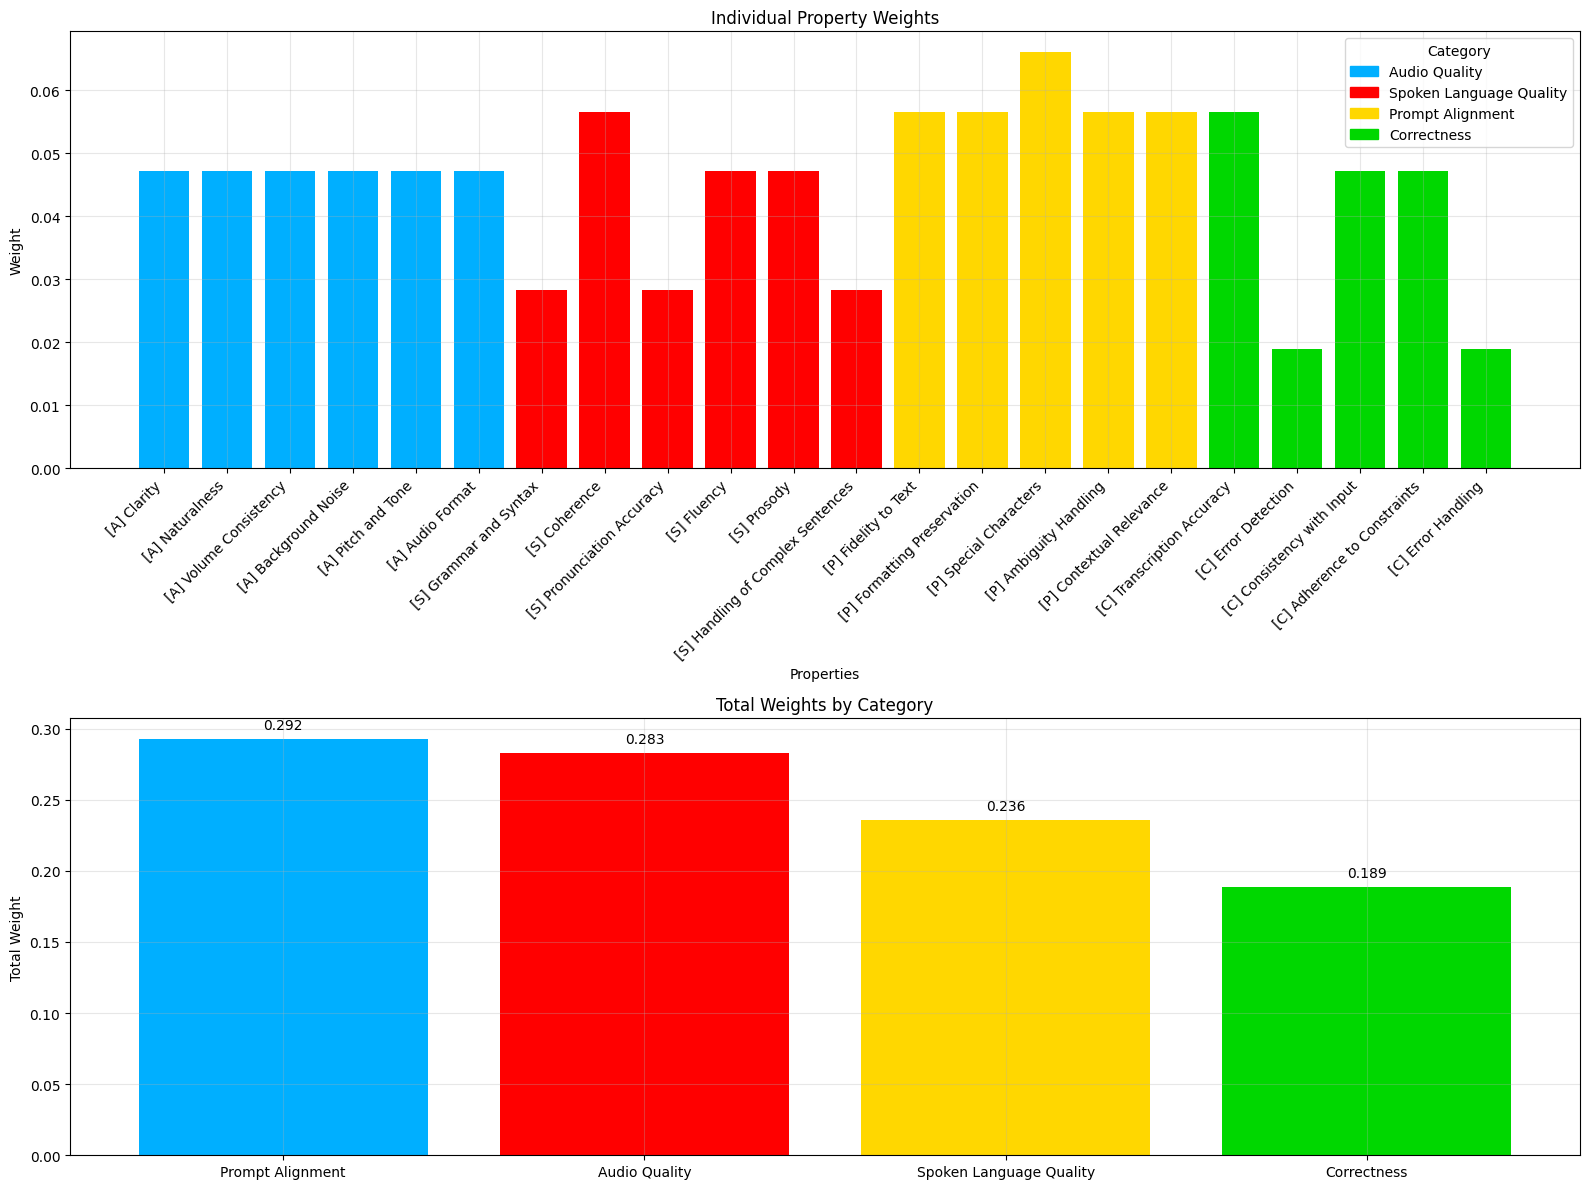

In [ ]:
# Plot 5: Weight Distribution Analysis (Clean Pandas Approach)
def plot_weight_distribution(weights):
    """Plot 5: Visualize the weight distribution across properties and categories."""

    weights_series = weights.iloc[0]

    # Create DataFrame for weight analysis
    df_weights = pd.DataFrame(
        {"Property": weights_series.index, "Weight": weights_series.values}
    )

    # Add category information
    df_weights["Category"] = df_weights["Property"].str[1]  # Extract category letter
    df_weights["Category_Name"] = df_weights["Category"].map(CATEGORY_NAMES)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # Plot 1: Individual property weights
    colors = [CATEGORY_COLORS[cat] for cat in df_weights["Category"]]

    ax1.bar(range(len(df_weights)), df_weights["Weight"], color=colors)
    ax1.set_xlabel("Properties")
    ax1.set_ylabel("Weight")
    ax1.set_title("Individual Property Weights")
    ax1.set_xticks(range(len(df_weights)))
    ax1.set_xticklabels(df_weights["Property"], rotation=45, ha="right")
    ax1.grid(True, alpha=0.3)

    legend_elements = [
        mpatches.Patch(color=CATEGORY_COLORS[c], label=CATEGORY_NAMES[c])
        for c in CATEGORY_COLORS.keys()
    ]
    ax1.legend(handles=legend_elements, title="Category")

    # Plot 2: Category-wise weight sums
    category_weights = (
        df_weights.groupby("Category_Name")["Weight"].sum().sort_values(ascending=False)
    )

    colors_cat = [
        CATEGORY_COLORS[cat]
        for cat in CATEGORY_COLORS.keys()
        if CATEGORY_NAMES[cat] in category_weights.index
    ]

    bars2 = ax2.bar(category_weights.index, category_weights.values, color=colors_cat)
    ax2.set_ylabel("Total Weight")
    ax2.set_title("Total Weights by Category")
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars2, category_weights.values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


plot_weight_distribution(weights)


## CDF Interpretation of scores

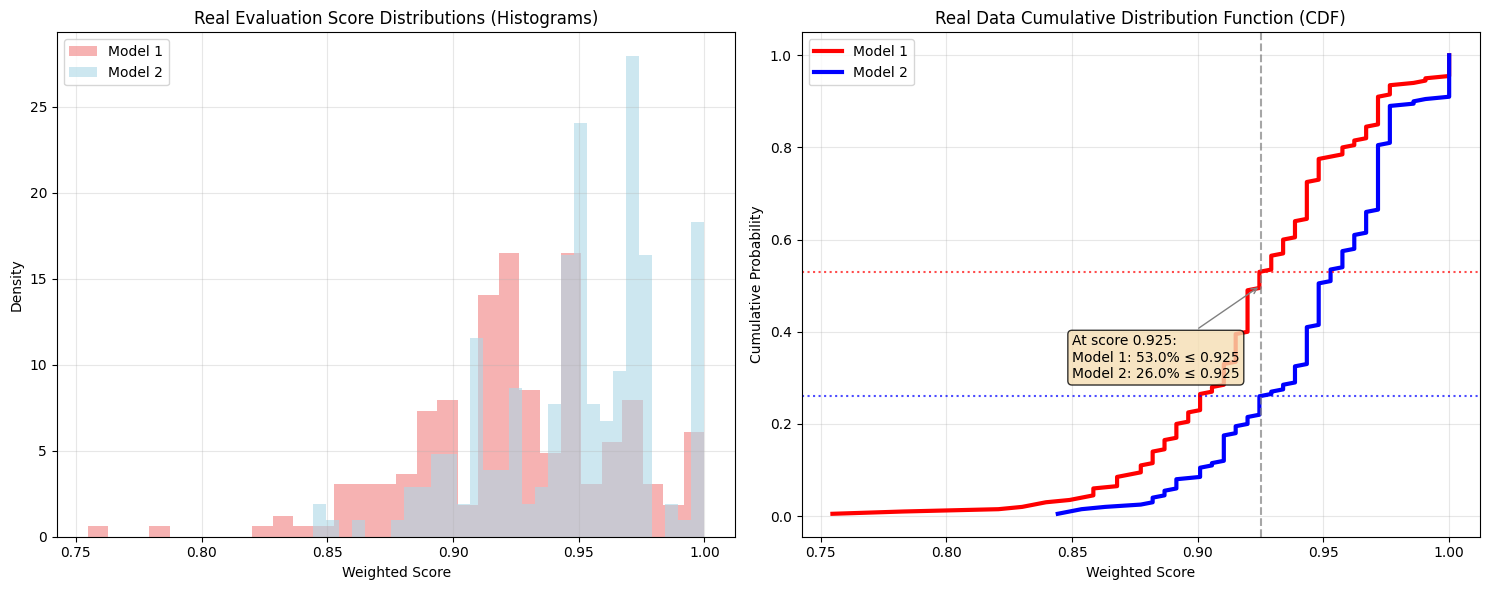

In [ ]:
"""
Script to explain CDF interpretation with real evaluation data.
"""


def create_real_data_cdf(
    model1_scores, model2_scores, weights, score_threshold: float = 0.925
):
    model1_scores = model1_df @ weights.T
    model2_scores = model2_df @ weights.T

    # Create CDF plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Histograms for context
    ax1.hist(
        model1_scores,
        alpha=0.6,
        label="Model 1",
        bins=30,
        color="lightcoral",
        density=True,
    )
    ax1.hist(
        model2_scores,
        alpha=0.6,
        label="Model 2",
        bins=30,
        color="lightblue",
        density=True,
    )
    ax1.set_xlabel("Weighted Score")
    ax1.set_ylabel("Density")
    ax1.set_title("Real Evaluation Score Distributions (Histograms)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: CDF
    sorted_m1 = np.sort(model1_scores.to_numpy().flatten())
    sorted_m2 = np.sort(model2_scores.to_numpy().flatten())
    y1 = np.arange(1, len(sorted_m1) + 1) / len(sorted_m1)
    y2 = np.arange(1, len(sorted_m2) + 1) / len(sorted_m2)

    ax2.plot(sorted_m1, y1, label="Model 1", color="red", linewidth=3)
    ax2.plot(sorted_m2, y2, label="Model 2", color="blue", linewidth=3)

    # Find probabilities at threshold
    prob_m1 = np.mean(model1_scores <= score_threshold)
    prob_m2 = np.mean(model2_scores <= score_threshold)

    # Add vertical line at threshold
    ax2.axvline(x=score_threshold, color="gray", linestyle="--", alpha=0.7)
    ax2.axhline(y=prob_m1, color="red", linestyle=":", alpha=0.7)
    ax2.axhline(y=prob_m2, color="blue", linestyle=":", alpha=0.7)

    # Add annotations
    ax2.annotate(
        f"At score {score_threshold}:\nModel 1: {prob_m1:.1%} ≤ {score_threshold}\nModel 2: {prob_m2:.1%} ≤ {score_threshold}",
        xy=(score_threshold, 0.5),
        xytext=(0.85, 0.3),
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
        arrowprops=dict(arrowstyle="->", color="gray"),
    )

    ax2.set_xlabel("Weighted Score")
    ax2.set_ylabel("Cumulative Probability")
    ax2.set_title("Real Data Cumulative Distribution Function (CDF)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("real_data_cdf_explanation.png", dpi=300, bbox_inches="tight")
    plt.show()


create_real_data_cdf(model1_df, model2_df, weights)